In [1]:
from IPython.display import Image

In [2]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import tqdm
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import random
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Set random seed for reproducibility
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Датасет

Поменяем структуру датасета, чтобы с ним было удобнее работать:

In [4]:
!cp -r /kaggle/input/hole-anomaly-detection/dataset /kaggle/working/

In [5]:
!mv /kaggle/working/dataset/proliv /kaggle/working/dataset/1
!mkdir /kaggle/working/dataset/proliv
!mv /kaggle/working/dataset/1 /kaggle/working/dataset/proliv/1

In [6]:
!mv /kaggle/working/dataset/train /kaggle/working/dataset/0
!mkdir /kaggle/working/dataset/train
!mv /kaggle/working/dataset/0 /kaggle/working/dataset/train/0

In [7]:
!mkdir /kaggle/working/dataset/test/0
!mkdir /kaggle/working/dataset/test/1

In [8]:
from pathlib import Path

with open('/kaggle/working/dataset/test/test_annotation.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        name, y = line.split()
        from_ = '/kaggle/working/dataset/test/imgs/' + name
        to = '/kaggle/working/dataset/test/' + y + '/' + name
        Path(from_).rename(to)

In [9]:
!rm -r /kaggle/working/dataset/test/imgs
!rm /kaggle/working/dataset/test/test_annotation.txt

Load data

In [10]:
image_size = 30

In [11]:
# Без пролива
train_ds = dset.ImageFolder(root='/kaggle/working/dataset/train',
                           transform=transforms.Compose([
                               transforms.Resize((30, 48)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
train_dataloader = torch.utils.data.DataLoader(train_ds,
                                         shuffle=True, num_workers=2)

# С проливом
spill_ds = dset.ImageFolder(root='/kaggle/working/dataset/proliv',
                           transform=transforms.Compose([
                               transforms.Resize((30, 48)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
spill_dataloader = torch.utils.data.DataLoader(spill_ds,
                                         shuffle=True, num_workers=2)

Test

In [12]:
test_ds = dset.ImageFolder(root='/kaggle/working/dataset/test',
                           transform=transforms.Compose([
                               transforms.Resize((30, 48)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
test_dataloader = torch.utils.data.DataLoader(test_ds,
                                         shuffle=False, num_workers=2)

Нарисуем часть картинок из датасета

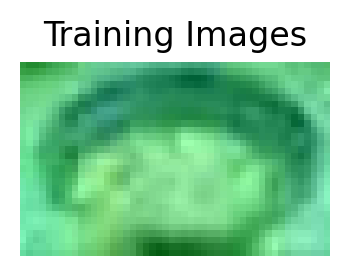

In [13]:
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(2,2))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:4], padding=2, normalize=True).cpu(),(1,2,0)))

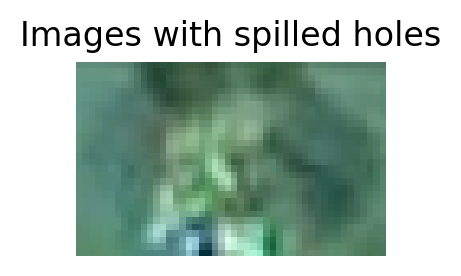

In [14]:
real_batch = next(iter(spill_ds))
plt.figure(figsize=(2,2))
plt.axis("off")
plt.title("Images with spilled holes")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:4], padding=2, normalize=True).cpu(),(1,2,0)))

In [15]:
for x, y in train_dataloader:
    print(x.size())
    break

torch.Size([1, 3, 30, 48])


## Автоэнкодер

In [16]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(4320, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 4320)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((1, 3, 30, 48))
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

Обучение

In [17]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm.tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [18]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device)

In [19]:
autoencoder_1 = train(autoencoder, train_dataloader, epochs=20)

100%|██████████| 20/20 [09:46<00:00, 29.30s/it]


Подберем границу

In [20]:
def create_list_of_mse(autoencoder, data):
    list_mse = []
    for x, y in data:
        z = autoencoder.encoder(x.to(device))
        z = autoencoder.decoder(z).to('cpu').detach().numpy()
        mse = ((x - z)**2).sum()
        list_mse.append(mse)
    return list_mse

In [47]:
def print_mse_hist(autoencoder, step=20, one_image=False):
    list_ok = create_list_of_mse(autoencoder, train_dataloader)
    print('min:', min(list_ok), 'max:', max(list_ok))
    
    list_spill = create_list_of_mse(autoencoder, spill_dataloader)
    print('min:', min(list_spill), 'max:', max(list_spill))
    bin_ranges = [i for i in range(50, 551, step)]
    
    fig = plt.figure()  
    plt.hist(list_ok, bins=bin_ranges, label='normal') 
    plt.xlabel('MSE')
    plt.ylabel('Amount of images')
    if one_image:
        plt.title('MSE for train images')
        plt.hist(list_spill, bins=bin_ranges, label='abnormal') #, edgecolor='black') 
        plt.legend()
    else:
        plt.title('MSE for nornal train images')
        fig = plt.figure()
        plt.hist(list_spill, bins=bin_ranges) 
        plt.title('MSE for abnormal train images')
        plt.xlabel('MSE')
        plt.ylabel('Amount of images')

min: tensor(53.4997) max: tensor(510.7179)
min: tensor(107.6664) max: tensor(209.5695)


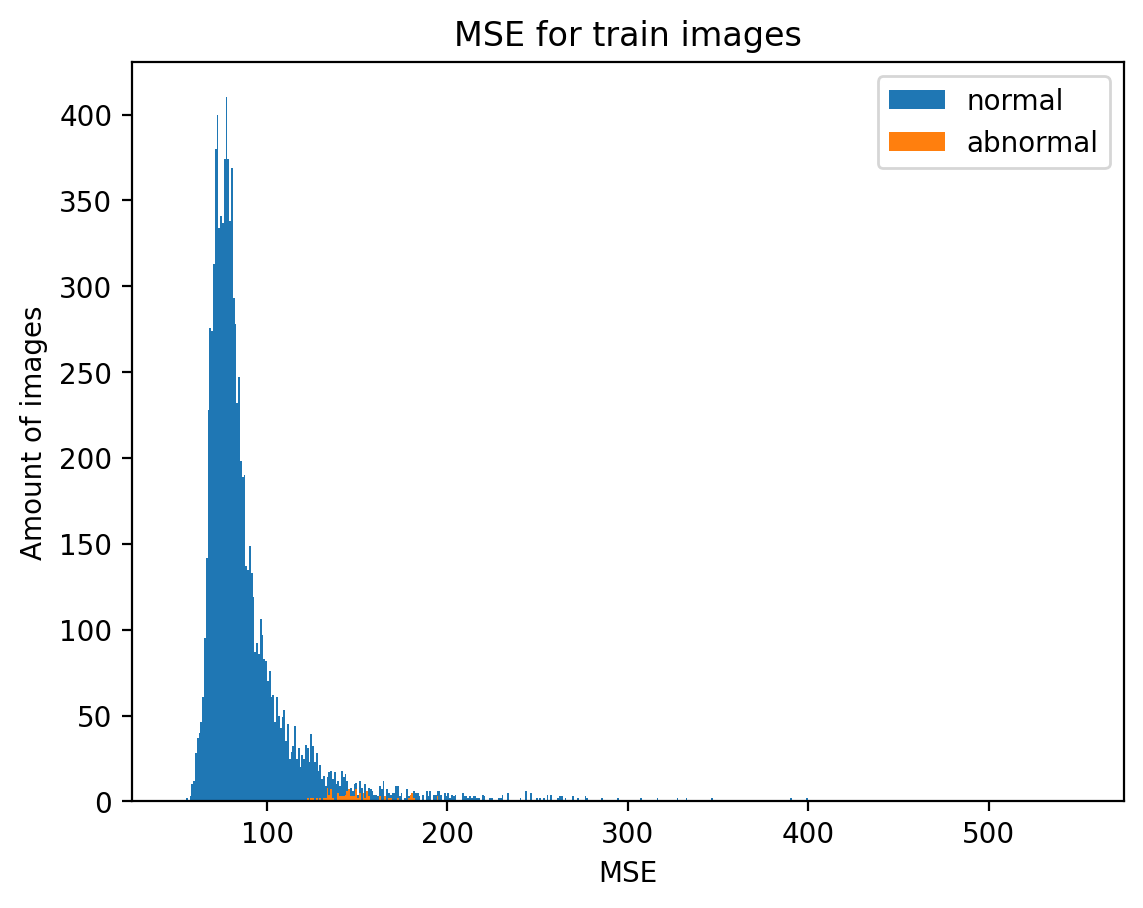

In [51]:
print_mse_hist(autoencoder_1, step=1, one_image=True)

In [52]:
def predict(autoencoder, data, threshold_l=110, threshold_r=140):
    y_pred = []
    for x, y in data:
        z = autoencoder.encoder(x.to(device))
        z = autoencoder.decoder(z).to('cpu').detach().numpy()
        mse = ((x - z)**2).sum()
        if mse > threshold_l and mse <= threshold_r:
            y_pred.append(1)
        else:
            y_pred.append(0) 
    return y_pred

In [24]:
y_pred = predict(autoencoder_1, test_dataloader, threshold_l=135, threshold_r=215)
m = confusion_matrix(test_ds.targets, y_pred)
print("True Positive Rate: ", m[1][1] / (m[1][1] + m[1][0]))
print("True Negative Rate: ", m[0][0] / (m[0][0] + m[0][1]))
m

True Positive Rate:  0.8449612403100775
True Negative Rate:  0.8425648021828104


array([[3088,  577],
       [  20,  109]])

Вот тут дальше идет неправильный подбор границы, потому что подстраиваемся под тестовую выборку

In [59]:
def print_threshold_selection_l(autoencoder, l, r, rr, step=1.0):
    tpr = []
    tnr = []
    y = []
    for i in np.arange(l, r, step):
        y_pred = predict(autoencoder, test_dataloader, threshold_l=i, threshold_r=rr)
        m = confusion_matrix(test_ds.targets, y_pred)
        tpr.append(m[1][1] / (m[1][1] + m[1][0]))
        tnr.append(m[0][0] / (m[0][0] + m[0][1]))
        y.append(i)
    plt.plot(y, tpr, label='TPR')
    plt.plot(y, tnr, label='TNR')
    plt.title('Качество класиффикации в зависимости от выставленного порога')
    plt.xlabel('Значение порога')
    plt.ylabel('Качество, %')
    plt.legend()

CPU times: user 6min 15s, sys: 1min 30s, total: 7min 46s
Wall time: 8min 54s


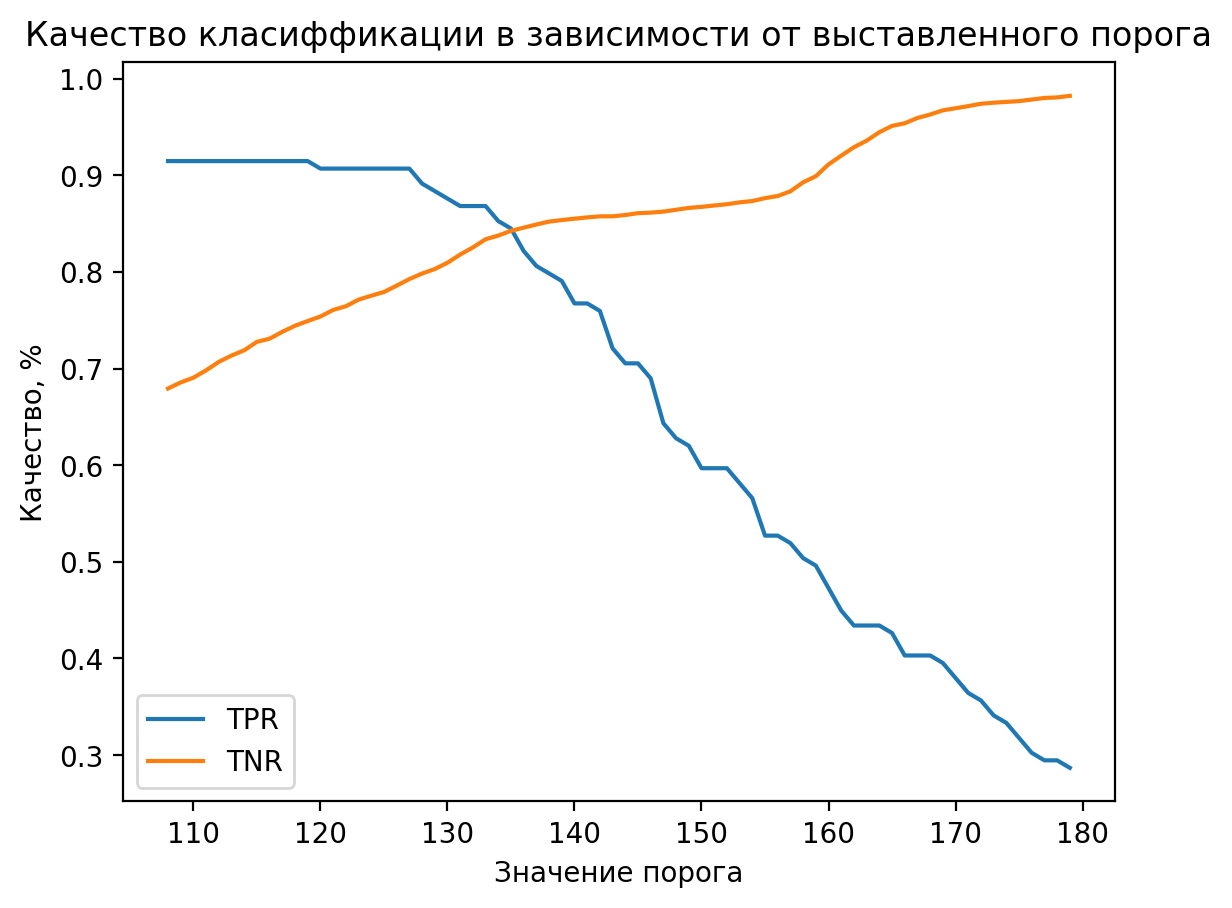

In [60]:
%%time

print_threshold_selection_l(autoencoder_1, 108.0, 180.0, 215.0)

In [57]:
def print_threshold_selection_r(autoencoder, l, r, ll, step=1.0):
    tpr = []
    tnr = []
    y = []
    for i in np.arange(l, r, step):
        y_pred = predict(autoencoder, test_dataloader, threshold_l=ll, threshold_r=i)
        m = confusion_matrix(test_ds.targets, y_pred)
        tpr.append(m[1][1] / (m[1][1] + m[1][0]))
        tnr.append(m[0][0] / (m[0][0] + m[0][1]))
        y.append(i)
    plt.plot(y, tpr, label='TPR')
    plt.plot(y, tnr, label='TNR')
    plt.title('Качество класиффикации в зависимости от выставленного порога')
    plt.xlabel('Значение порога')
    plt.ylabel('Качество, %')
    plt.legend()

CPU times: user 4min 47s, sys: 1min 9s, total: 5min 56s
Wall time: 6min 48s


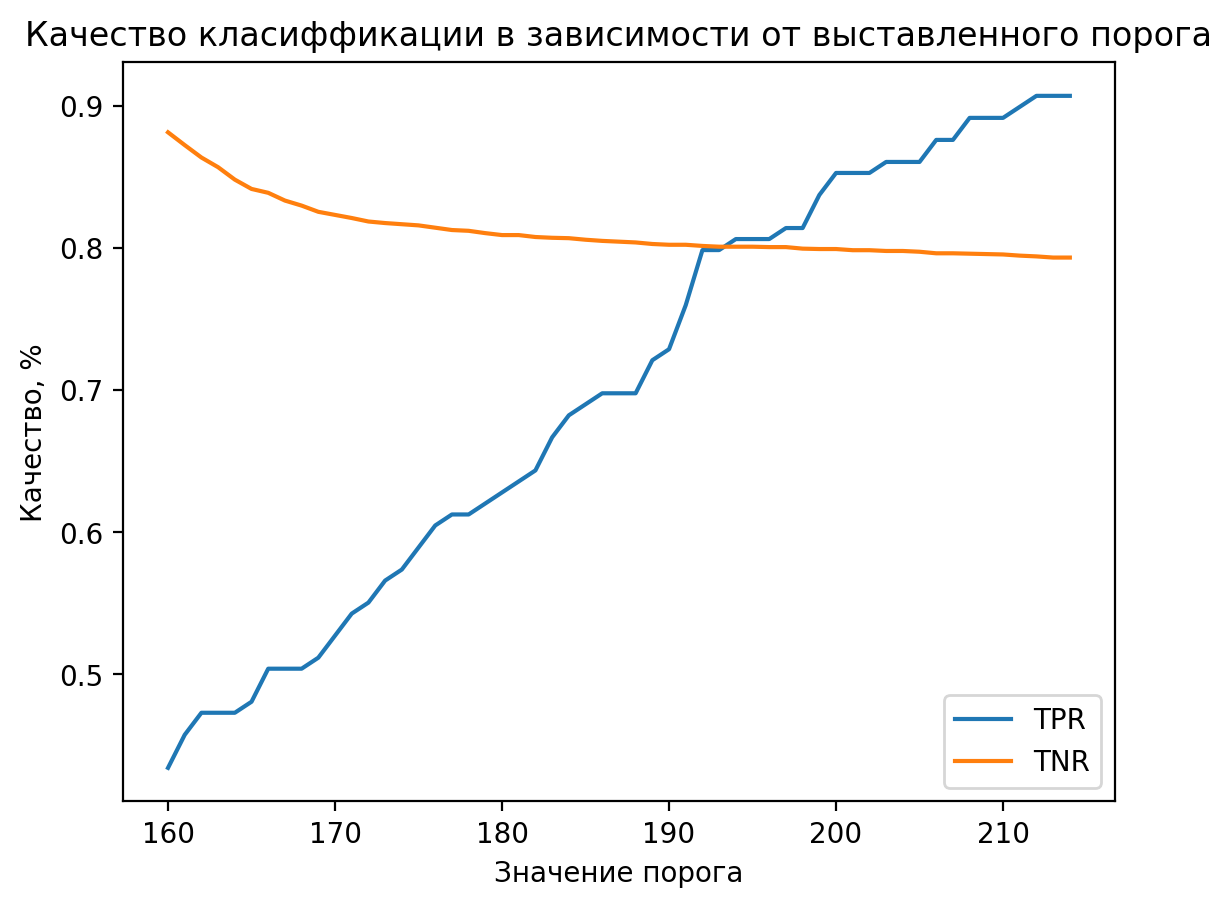

In [58]:
%%time

print_threshold_selection_r(autoencoder_1, 160.0, 215.0, 127.0)

## Вариационный автоэнкодер

Особо ничего не поменялось

In [29]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(4320, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

Обучение

In [30]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm.tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [31]:
vae = VariationalAutoencoder(latent_dims).to(device)
vae = train(vae, train_dataloader)

100%|██████████| 20/20 [12:19<00:00, 36.95s/it]


min: tensor(29.9031) max: tensor(510.2827)
min: tensor(90.0104) max: tensor(208.5233)


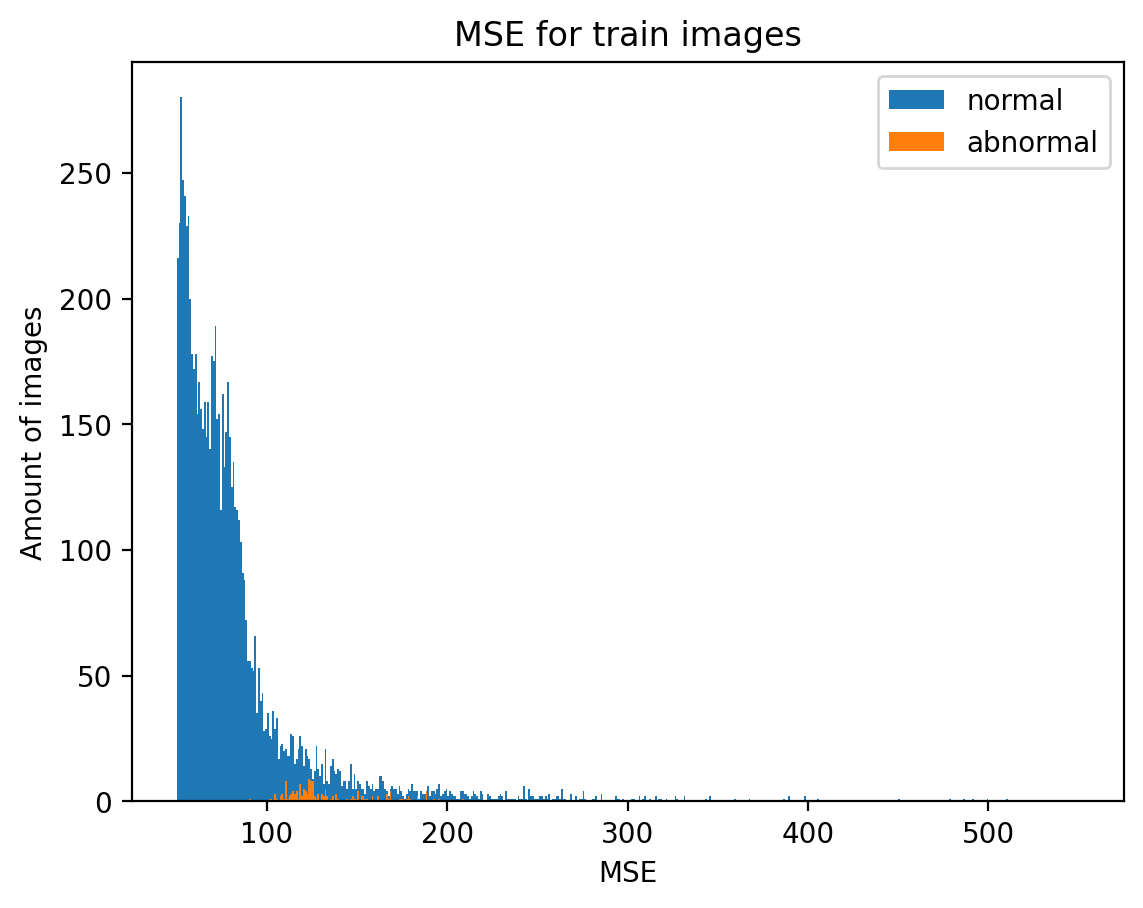

In [48]:
print_mse_hist(vae, step=1, one_image=True)

In [49]:
y_pred = predict(vae, test_dataloader, threshold_l=110, threshold_r=140)
m = confusion_matrix(test_ds.targets, y_pred)
print("True Positive Rate: ", m[1][1] / (m[1][1] + m[1][0]))
print("True Negative Rate: ", m[0][0] / (m[0][0] + m[0][1]))
m

True Positive Rate:  0.3333333333333333
True Negative Rate:  0.8379263301500682


array([[3071,  594],
       [  86,   43]])

In [35]:
vae2 = VariationalAutoencoder(100).to(device)
vae2 = train(vae, train_dataloader, epochs=5)

100%|██████████| 5/5 [03:04<00:00, 36.99s/it]


min: tensor(30.2887) max: tensor(509.7056)
min: tensor(90.2930) max: tensor(209.2046)


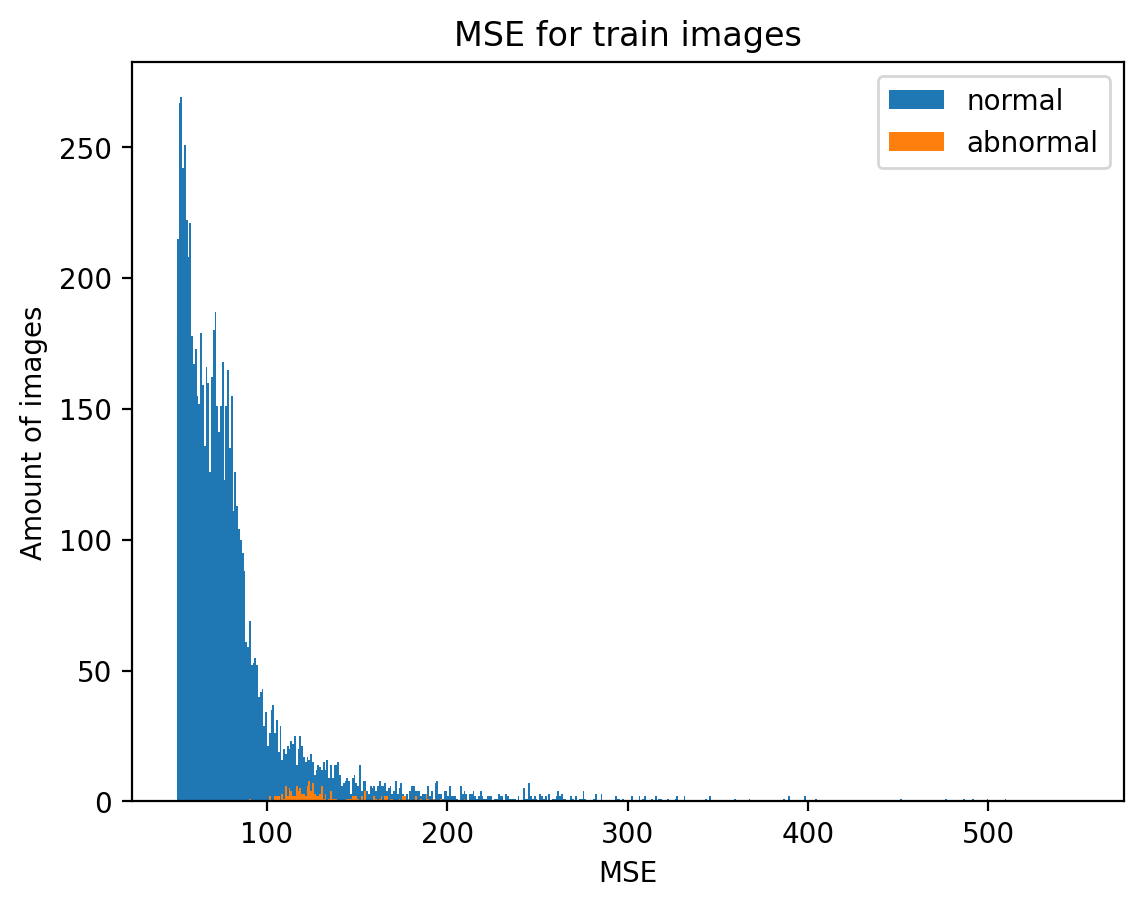

In [50]:
print_mse_hist(vae2, step=1, one_image=True)

In [37]:
y_pred = predict(vae2, test_dataloader, threshold_l=130, threshold_r=220)
m = confusion_matrix(test_ds.targets, y_pred)
print("True Positive Rate: ", m[1][1] / (m[1][1] + m[1][0]))
print("True Negative Rate: ", m[0][0] / (m[0][0] + m[0][1]))
m

True Positive Rate:  0.7209302325581395
True Negative Rate:  0.8431105047748977


array([[3090,  575],
       [  36,   93]])

In [62]:
!pip freeze > requirements.txt